In [1]:
using DrWatson
@quickactivate "SpinOneChain"

  Activating environment at `C:\Users\kyungminlee\Dropbox\Code\SpinOneChain\Project.toml`


In [2]:
using JLD2
using Glob
using PyPlot
using PyCall
using DataFrames
using SQLite
using DBInterface

inset_locator = pyimport("mpl_toolkits.axes_grid1.inset_locator")
gridspec = pyimport("matplotlib.gridspec")

PyObject <module 'matplotlib.gridspec' from 'C:\\Users\\kyungminlee\\miniconda3\\envs\\conda_jl\\lib\\site-packages\\matplotlib\\gridspec.py'>

In [3]:
df = DataFrame()
for fpath in Glob.glob("domainwall*.jld2", datadir())
    @load fpath N D energy state
    push!(df, (N=N, D=D, energy=energy, state=state))
end

In [4]:
combined_df = DataFrame()
for subdf in groupby(df, [:N, :D])
    N = subdf[1, :N]
    D = subdf[1, :D]
    E0 = first(subdf[subdf[:, :state] .== 1, :energy])
    E1 = first(subdf[subdf[:, :state] .== 2, :energy])
    E2 = first(subdf[subdf[:, :state] .== 3, :energy])
    push!(combined_df, (N=N, D=D, E0=E0, E1=E1, E2=E2))
end

In [5]:
unique(df[:, :N])

6-element Vector{Int64}:
 128
 180
  32
  48
  64
  96

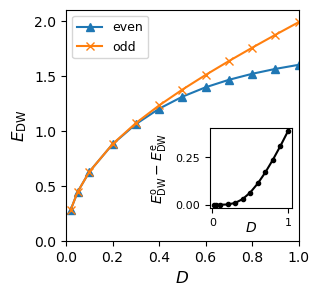

In [6]:
# subdf = df[df[:, :N] .== 32, :]
subdf = combined_df[combined_df[:, :N] .== 180, :]
subdf = subdf[sortperm(subdf, :D), :]
# subdf = subdf[subdf[:, :]
fig = PyPlot.figure(figsize=(3, 3))
ax = fig.gca()
ax.plot(subdf[:, :D], subdf[:, :E1] - subdf[:, :E0], "^-", alpha=1, label="even")
ax.plot(subdf[:, :D], subdf[:, :E2] - subdf[:, :E0], "x-", alpha=1, label="odd")
ax.set_xlim(0, 1)
ax.set_ylim(0, 2.1)
ax.set_xlabel("\$D\$", fontsize=12)
ax.set_ylabel("\$E_{\\mathrm{DW}}\$", fontsize=12)
ax.legend(fontsize=9)

axins = inset_locator.inset_axes(ax, width="100%", height="100%", bbox_to_anchor=(0.65, 0.17, 0.35, 0.35), bbox_transform=ax.transAxes)
axins.plot(subdf[:, :D], subdf[:, :E2] - subdf[:, :E1], "k.-", alpha=1)
axins.set_xlabel("\$D\$", fontsize=10, labelpad=-5)
axins.set_ylabel(raw"$E_{\mathrm{DW}}^{\mathrm{o}} - E_{\mathrm{DW}}^{\mathrm{e}}$")
PyPlot.setp(axins.get_xticklabels(), fontsize=8)
PyPlot.setp(axins.get_yticklabels(), fontsize=8)
fig.savefig("domain-wall-energy.pdf", dpi=300, bbox_inches="tight")

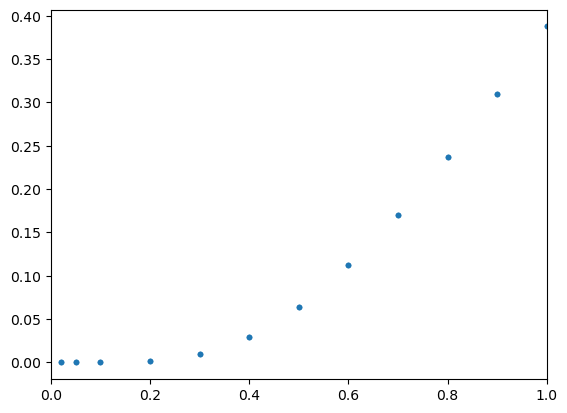

(0.0, 1.0)

In [7]:
# subdf = df[df[:, :N] .== 32, :]
subdf = combined_df
PyPlot.plot(subdf[:, :D], subdf[:, :E2] - subdf[:, :E1], ".", alpha=0.5)
PyPlot.xlim(0, 1)


In [8]:
# #subdf = df[df[:, :N] .== 32, :]
# PyPlot.plot(subdf[:, :D], subdf[:, :E2] - subdf[:, :E1], "o", alpha=1)
# PyPlot.xscale("log")
# PyPlot.yscale("log")
# #PyPlot.xlim(0, 1)
# #PyPlot.ylim(0, 2)

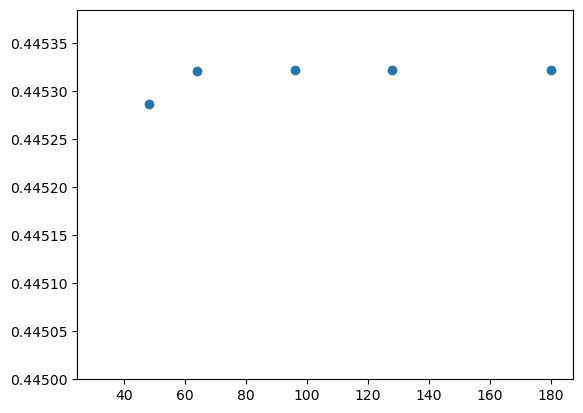

subdf[:, :E1] - subdf[:, :E0] = [0.4453215587445243, 0.44532155874537693, 0.44405817604033615, 0.4452863160942968, 0.4453205671533027, 0.4453215579602414]


(0.445, 0.445384727880629)

In [9]:
let
    subdf = combined_df[combined_df[:, :D] .== 0.05, :]
    @show subdf[:, :E1] - subdf[:, :E0]
    PyPlot.plot(subdf[:, :N], subdf[:, :E1] - subdf[:, :E0], "o", alpha=1)
    PyPlot.ylim(0.4450, nothing)
end

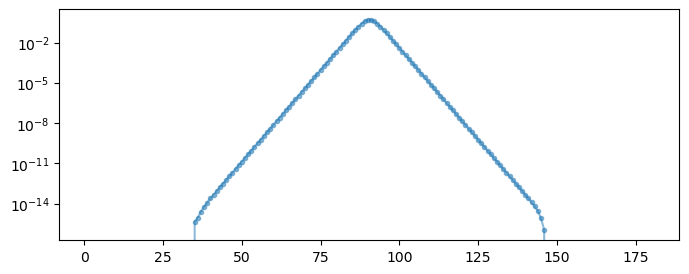

In [10]:
N = 180

fig = PyPlot.figure(figsize=(8, 3))
let D=0.1
    @load datadir("domainwall_N=$(N)_D=$(D)_state=2.jld2") Sz Sz2
    midpoint = (N+1)/2
#     lc = ceil(Int, midpoint)
#     xs = 0.5:(N-lc+0.5)
#     ys = 1.0 .- abs.(Sz[lc:N])
    xs = 1:N
    ys = 1 .- Sz2
#     xs = 0.5:(15+0.5)
#     ys = 1.0 .- abs.(Sz[lc:lc+15])    
    PyPlot.plot(xs, ys, "o-", label="D=$D", alpha=0.5, markersize=3)
end
PyPlot.yscale("log")

# for (iD, D) in enumerate([1.0, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
#     @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
#     midpoint = N/2
#     lc = ceil(Int, midpoint)
#     xs = 0:(N-lc)
#     ys = 1.0 .- abs.(Sz[lc:N])    
# #     xs = 0:15
# #     ys = 1.0 .- abs.(Sz[lc:lc+15])
#     PyPlot.plot(xs, ys, "^-", color=colors[iD], alpha=0.5, markersize=3) #, label="D=$D")
# end
# PyPlot.xlim(0, nothing)
# PyPlot.yscale("log")
# PyPlot.ylim(1E-13, nothing)
# PyPlot.xlim(-0.5, N/2-0.5)
# PyPlot.legend(loc=1, fontsize=6)

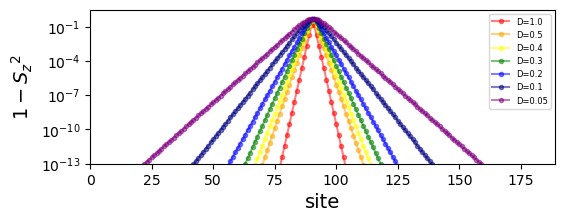

PyObject Text(35.20000000000001, 0.5, '$1 - {S_z}^2$')

In [11]:
plotcolors = ["red", "orange", "yellow", "green", "blue", "navy", "purple"]
N = 180

fig = PyPlot.figure(figsize=(6, 2))
for (iD, D) in enumerate([1.0, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=2.jld2") Sz Sz2
    midpoint = (N+1)/2
    lc = ceil(Int, midpoint)
#     xs = 0.5:(N-lc+0.5)
#     ys = 1.0 .- abs.(Sz[lc:N])
    xs = 1:N
    ys = 1.0 .- abs.(Sz2)

#     xs = 0.5:(15+0.5)
#     ys = 1.0 .- abs.(Sz[lc:lc+15])    
    PyPlot.plot(xs, ys, "o-", color=plotcolors[iD], label="D=$D", alpha=0.5, markersize=3)
end

# for (iD, D) in enumerate([1.0, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
#     @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
#     midpoint = N/2
#     lc = ceil(Int, midpoint)
# #     xs = 0:(N-lc)
# #     ys = 1.0 .- abs.(Sz[lc:N])    
#     xs = 1:N
#     ys = 1.0 .- abs.(Sz2)
# #     xs = 0:15
# #     ys = 1.0 .- abs.(Sz[lc:lc+15])
#     PyPlot.plot(xs, ys, "^-", color=plotcolors[iD], alpha=0.5, markersize=3) #, label="D=$D")
# end
PyPlot.xlim(0, nothing)
PyPlot.yscale("log")
PyPlot.ylim(1E-13, nothing)
#PyPlot.xlim(-0.5, N/2-0.5)
PyPlot.legend(loc=1, fontsize=6)
PyPlot.xlabel("site", fontsize=14)
PyPlot.ylabel("\$1 - {S_z}^2\$", fontsize=14)

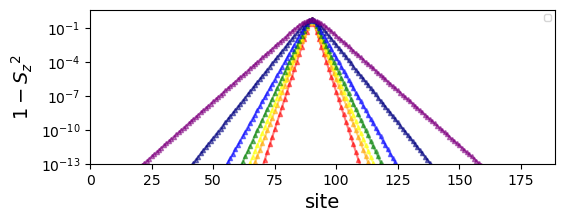

No handles with labels found to put in legend.


PyObject Text(35.20000000000001, 0.5, '$1 - {S_z}^2$')

In [12]:
plotcolors = ["red", "orange", "yellow", "green", "blue", "navy", "purple"]
N = 180

fig = PyPlot.figure(figsize=(6, 2))
# for (iD, D) in enumerate([1.0, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
#     @load datadir("domainwall_N=$(N)_D=$(D)_state=2.jld2") Sz Sz2
#     midpoint = (N+1)/2
#     lc = ceil(Int, midpoint)
# #     xs = 0.5:(N-lc+0.5)
# #     ys = 1.0 .- abs.(Sz[lc:N])
#     xs = 1:N
#     ys = 1.0 .- abs.(Sz2)

# #     xs = 0.5:(15+0.5)
# #     ys = 1.0 .- abs.(Sz[lc:lc+15])    
#     PyPlot.plot(xs, ys, "o-", color=plotcolors[iD], label="D=$D", alpha=0.5, markersize=3)
# end

for (iD, D) in enumerate([1.0, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
    midpoint = N/2
    lc = ceil(Int, midpoint)
#     xs = 0:(N-lc)
#     ys = 1.0 .- abs.(Sz[lc:N])    
    xs = 1:N
    ys = 1.0 .- abs.(Sz2)
#     xs = 0:15
#     ys = 1.0 .- abs.(Sz[lc:lc+15])
    PyPlot.plot(xs, ys, "^-", color=plotcolors[iD], alpha=0.5, markersize=3) #, label="D=$D")
end
PyPlot.xlim(0, nothing)
PyPlot.yscale("log")
PyPlot.ylim(1E-13, nothing)
#PyPlot.xlim(-0.5, N/2-0.5)
PyPlot.legend(loc=1, fontsize=6)
PyPlot.xlabel("site", fontsize=14)
PyPlot.ylabel("\$1 - {S_z}^2\$", fontsize=14)

In [13]:
mpl_cm = pyimport("matplotlib.cm")

PyObject <module 'matplotlib.cm' from 'C:\\Users\\kyungminlee\\miniconda3\\envs\\conda_jl\\lib\\site-packages\\matplotlib\\cm.py'>

In [14]:
mpl_cm.jet

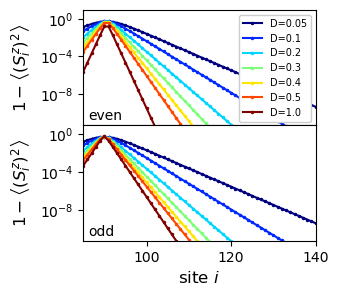

In [18]:
plotcolors = ["red", "orange", "yellow", "green", "blue", "navy", "purple"]
plotcolors = mpl_cm.jet.(0:(1/6.0):1)
N = 180

fig = PyPlot.figure(figsize=(3, 3))
ax = fig.add_subplot(2,1,1)
# for (iD, D) in enumerate([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0])
for (iD, D) in enumerate([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=2.jld2") Sz Sz2
    midpoint = (N+1)/2
    lc = ceil(Int, midpoint)
    xs = 1:N
    ys = 1.0 .- abs.(Sz2)
    ax.plot(xs, ys, ".-", color=plotcolors[iD], label="D=$D", alpha=1, markersize=3)
#     ax.plot(xs, ys, ".-", color=mpl_cm.jet(D), label="D=$D", alpha=1, markersize=3)
end
ax.legend(loc=1, fontsize=7, framealpha=1)
ax.set_ylabel("\$1 - \\left\\langle (S_i^z)^2 \\right\\rangle\$", fontsize=12)
PyPlot.setp(ax.get_xticklabels(), visible=false)
ax.text(0.02, 0.02, "even", ha="left", va="bottom", transform=ax.transAxes)

ax = fig.add_subplot(2,1,2, sharex=ax, sharey=ax)
for (iD, D) in enumerate([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
    midpoint = N/2
    lc = ceil(Int, midpoint)
    xs = 1:N
    ys = 1.0 .- abs.(Sz2)
    ax.plot(xs, ys, ".-", color=plotcolors[iD], alpha=1, markersize=3) #, label="D=$D")
#     ax.plot(xs, ys, ".-", color=mpl_cm.jet(D), alpha=1, markersize=3) #, label="D=$D")
end
ax.set_xlim(85, 140)
ax.set_yscale("log")
ax.set_ylim(5E-12, 9)
ax.set_xlabel("site \$i\$", fontsize=12)
ax.set_ylabel("\$1 - \\left\\langle (S_i^z)^2 \\right\\rangle\$", fontsize=12)
ax.text(0.02, 0.02, "odd", ha="left", va="bottom", transform=ax.transAxes)

fig.subplots_adjust(hspace=0)

fig.savefig("domain-wall-profile.pdf", dpi=300, bbox_inches="tight")

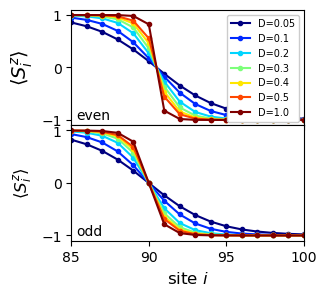

In [19]:
plotcolors = ["red", "orange", "yellow", "green", "blue", "navy", "purple"]
plotcolors = mpl_cm.jet.(0:(1/6.0):1)
N = 180

fig = PyPlot.figure(figsize=(3, 3))
ax = fig.add_subplot(2,1,1)
# for (iD, D) in enumerate([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0])
for (iD, D) in enumerate([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=2.jld2") Sz Sz2
    midpoint = (N+1)/2
    lc = ceil(Int, midpoint)
    xs = 1:N
    ys = Sz
    ax.plot(xs, ys, "o-", color=plotcolors[iD], label="D=$D", alpha=1, markersize=3)
#     ax.plot(xs, ys, "o-", color=color=mpl_cm.jet(D), label="D=$D", alpha=1, markersize=3)    
end
ax.legend(loc=1, fontsize=7, framealpha=1)
ax.set_ylabel("\$\\langle S_i^z \\rangle \$", fontsize=14)
PyPlot.setp(ax.get_xticklabels(), visible=false)
ax.text(0.02, 0.02, "even", ha="left", va="bottom", transform=ax.transAxes)

ax = fig.add_subplot(2,1,2, sharex=ax, sharey=ax)
for (iD, D) in enumerate([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
    midpoint = N/2
    lc = ceil(Int, midpoint)
    xs = 1:N
    ys = Sz
    ax.plot(xs, ys, "o-", color=plotcolors[iD], alpha=1, markersize=3) #, label="D=$D")
#     ax.plot(xs, ys, "o-", color=mpl_cm.jet(D), alpha=1, markersize=3) #, label="D=$D")
end
ax.set_xlim(85, 100)
# ax.set_yscale("log")
# ax.set_ylim(5E-12, 9)
ax.set_xlabel("site \$i\$", fontsize=12)
ax.set_ylabel("\$\\langle S_i^z \\rangle \$", fontsize=12)
ax.text(0.02, 0.02, "odd", ha="left", va="bottom", transform=ax.transAxes)

fig.subplots_adjust(hspace=0)

fig.savefig("domain-wall-spinprofile.pdf", dpi=300, bbox_inches="tight")

In [20]:
using Statistics

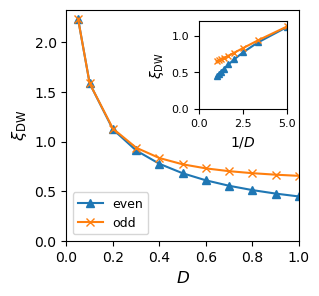

In [64]:
# plotcolors = ["red", "orange", "yellow", "green", "blue", "navy", "purple"]
N = 180

fig = PyPlot.figure(figsize=(3, 3))
ax = fig.gca()
axins = inset_locator.inset_axes(ax, width="100%", height="100%", bbox_to_anchor=[0.6, 0.6, 0.38, 0.38], bbox_transform=ax.transAxes)
axins.plot()


datapoint_xs = Float64[]
datapoint_ys = Float64[]
for (iD, D) in enumerate([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=2.jld2") Sz Sz2
    midpoint = (N+1)/2
    lc = ceil(Int, midpoint)
    xs = 0.5:(N-lc+0.5)
    ys = 1.0 .- abs.(Sz[lc:N])
    
    xs = (xs[2:end] .+ xs[1:end-1] ) .* 0.5
    ys = ys[2:end] ./ ys[1:end-1]
    beta = median(ys[.! isnan.(ys)])
    push!(datapoint_xs, D)
    push!(datapoint_ys, -1/log(beta))
end
ax.plot(datapoint_xs, datapoint_ys, "^-", label="even")
axins.plot(1 ./ datapoint_xs, datapoint_ys, "^-", label="even", markersize=4)

datapoint_xs = Float64[]
datapoint_ys = Float64[]
for (iD, D) in enumerate([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
    midpoint = N/2
    lc = ceil(Int, midpoint)
    xs = 0:(N-lc)
    ys = 1.0 .- abs.(Sz[lc:N])
    
    xs = (xs[2:end] .+ xs[1:end-1] ) .* 0.5
    ys = ys[2:end] ./ ys[1:end-1]
    beta = median(ys[.! isnan.(ys)])
    push!(datapoint_xs, D)
    push!(datapoint_ys, -1/log(beta))
end
ax.plot(datapoint_xs, datapoint_ys, "x-", label="odd")
axins.plot(1 ./ datapoint_xs, datapoint_ys, "x-", label="even", markersize=4)

ax.set_xlabel(raw"$D$", fontsize=12)
ax.set_ylabel(raw"$\xi_{\mathrm{DW}}$", fontsize=12)
ax.legend(fontsize=9, loc=3)
ax.set_ylim(0, nothing)
ax.set_xlim(0, 1)

#axins.set_xlim(0.8, 5)
#axins.set_ylim(0.35, 1.2)
axins.set_xlim(0, 5)
axins.set_ylim(0, 1.2)
axins.set_xlabel(raw"$1/D$")
axins.set_ylabel(raw"$\xi_{\mathrm{DW}}$")
PyPlot.setp(axins.get_xticklabels(), fontsize=8)
PyPlot.setp(axins.get_yticklabels(), fontsize=8)

fig.savefig("domain-wall-thickness.pdf", dpi=300, bbox_inches="tight")
# PyPlot.xlim(0, nothing)
# # PyPlot.yscale("log")
# # PyPlot.ylim(1E-13, nothing)
# # #PyPlot.xlim(-0.5, N/2-0.5)
# # PyPlot.legend(loc=1, fontsize=6)
# PyPlot.xlabel("site", fontsize=14)
# PyPlot.ylabel("\$1 - {S_z}^2\$", fontsize=14)

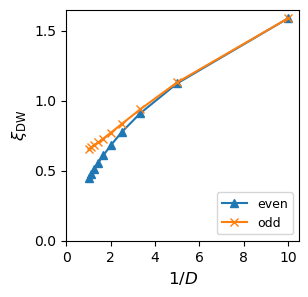

In [56]:
# plotcolors = ["red", "orange", "yellow", "green", "blue", "navy", "purple"]
N = 180

fig = PyPlot.figure(figsize=(3, 3))
ax = fig.gca()

datapoint_xs = Float64[]
datapoint_ys = Float64[]
for (iD, D) in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=2.jld2") Sz Sz2
    midpoint = (N+1)/2
    lc = ceil(Int, midpoint)
    xs = 0.5:(N-lc+0.5)
    ys = 1.0 .- abs.(Sz[lc:N])
    
    xs = (xs[2:end] .+ xs[1:end-1] ) .* 0.5
    ys = ys[2:end] ./ ys[1:end-1]
    beta = median(ys[.! isnan.(ys)])
    push!(datapoint_xs, D)
    push!(datapoint_ys, -1/log(beta))
end
ax.plot(1 ./ datapoint_xs, datapoint_ys, "^-", label="even")

datapoint_xs = Float64[]
datapoint_ys = Float64[]
for (iD, D) in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
    midpoint = N/2
    lc = ceil(Int, midpoint)
    xs = 0:(N-lc)
    ys = 1.0 .- abs.(Sz[lc:N])
    
    xs = (xs[2:end] .+ xs[1:end-1] ) .* 0.5
    ys = ys[2:end] ./ ys[1:end-1]
    beta = median(ys[.! isnan.(ys)])
    push!(datapoint_xs, D)
    push!(datapoint_ys, -1/log(beta))
end
ax.plot(1 ./ datapoint_xs, datapoint_ys, "x-", label="odd")

ax.set_xlabel(raw"$1/D$", fontsize=12)
ax.set_ylabel(raw"$\xi_{\mathrm{DW}}$", fontsize=12)
ax.legend(fontsize=9, loc=4)
ax.set_xlim(0, 10.5)
ax.set_ylim(0, 1.65)

# ax.set_xticks([0, 10/5, 10/4, 10/3, 10/2, 10/1])
# ax.set_xticklabels([raw"$\infty$", "0.5", "4", "3", "2", "1"])

# dvals = [0.1, 0.2, 0.3, 0.5, 1.0]
# ax.set_xticks([0, (1 ./ dvals)...])
# ax.set_xticklabels([raw"$\infty$", (string.(dvals))...])

ax.set_xticks([0, 2, 4, 6, 8, 10])
ax.set_yticks([0, 0.5, 1, 1.5])
# ax.set_xlim(0, 1)
fig.savefig("domain-wall-thickness.pdf", dpi=300, bbox_inches="tight")
# PyPlot.xlim(0, nothing)
# # PyPlot.yscale("log")
# # PyPlot.ylim(1E-13, nothing)
# # #PyPlot.xlim(-0.5, N/2-0.5)
# # PyPlot.legend(loc=1, fontsize=6)
# PyPlot.xlabel("site", fontsize=14)
# PyPlot.ylabel("\$1 - {S_z}^2\$", fontsize=14)

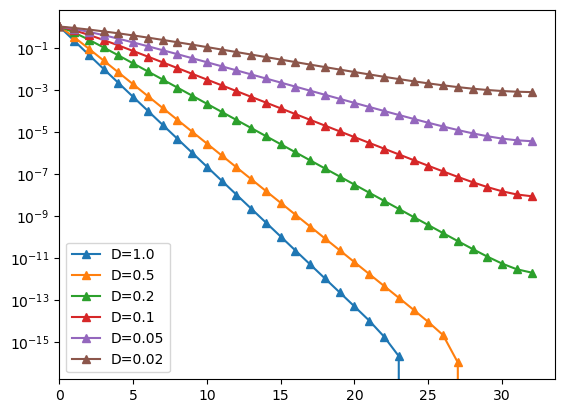

PyObject <matplotlib.legend.Legend object at 0x0000000001A84FD0>

In [9]:
for D in [1.0, 0.5, 0.2, 0.1, 0.05, 0.02]
    N = 64
    @load datadir("domainwall_N=$(N)_D=$(D)_state=3.jld2") Sz Sz2
    midpoint = N/2
    lc = ceil(Int, midpoint)
    xs = 0:(N-lc)
    ys = 1.0 .- abs.(Sz[lc:N])
    PyPlot.plot(xs, ys, "^-", label="D=$D")
end
PyPlot.xlim(0, nothing)
PyPlot.yscale("log")
PyPlot.legend()

In [10]:
PyPlot.plot(1 .- abs.(Sz1), "x-", label=raw"$\uparrow\downarrow$")
PyPlot.plot(1 .- abs.(Sz2), "^-", label=raw"$\uparrow0\downarrow$")
# PyPlot.xlim(10, 20)
PyPlot.legend()
# PyPlot.xlim(15, 45)

LoadError: UndefVarError: Sz1 not defined